In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def LoadBatch(filename):
    dict = unpickle(filename)
    X = dict['data']
    Y = dict['labels']
    Y_one_hot = one_hot_encode(Y)
    return X, Y, Y_one_hot

def unpickle(filename):
    """ Copied from the dataset website """
    import pickle
    with open('datasets/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1') #encoding='latin1' is required for unpickling NumPy arrays
    return dict

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

def normalize(x, mean, std):
    return (x-mean)/std

def EvaluateClassifier(X, W, b):
    s = (W @ X.T) + b
    p = softmax(s)    
    return p

def softmax(x):
    """ Standard definition of code - Modified to avoid overflow error """
    p = np.exp(x - np.max(x, axis=0))/np.exp(x - np.max(x, axis=0)).sum(axis=0)
    return p

#Bonus SVM loss
def ComputeCost(X,Y,W,b,lamda):
    N = X.shape[1] 
    s_j = EvaluateClassifier(X.T, W, b)
    s_y = s_j.T[np.arange(s_j.shape[1]), np.argmax(Y, axis=0)].T
    margins = np.maximum(0, s_j - np.asarray(s_y) + 1)
    margins.T[np.arange(N), np.argmax(Y, axis=0)] = 0
    svm_loss = Y.shape[0] * np.mean(np.sum(margins, axis=1))
    cost = 1/N * svm_loss + 0.5 * lamda * np.sum(W**2)
    return cost, margins

def ComputeAccuracy(X, Y, W, b):
    p = EvaluateClassifier(X, W, b)
    max_idx = np.argmax(p, axis=0)
    acc = np.count_nonzero((Y - max_idx)==0)/X.shape[0]
    return acc

#Bonus Gradients computed according to SVM loss
def ComputeGradients(X, Y, W, b, lamda):
    N = X.shape[1]
    _, margins = ComputeCost(X, Y, W, b, lamda)
    margins[margins > 0] = 1
    margins_row_sum = np.sum(margins, axis=0)
    margins.T[np.arange(N), np.argmax(Y, axis=0)] = -margins_row_sum.T
    grad_w = np.dot(margins, X.T) / N + lamda * W
    grad_b = np.reshape(np.sum(margins, axis=1)/margins.shape[1], b.shape)
    return grad_w, grad_b

def montage(W):
    """ Display the image for each label in W """
    fig, ax = plt.subplots(2,5)
    for i in range(2):
        for j in range(5):
            im = W [5 * i + j,:].reshape (32,32,3, order = 'F')
            sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
            sim = sim.transpose(1,0,2)
            ax[i][j].imshow(sim, interpolation='nearest')
            ax[i][j].set_title("y="+str(5*i+j))
            ax[i][j].axis('off')
    plt.show()

def mini_batch_gd(n, n_batch, X_train, Y_train, X_train_val, Y_train_val, Y_trn, Y_val, eta, n_epochs, W, b, lamda):
    w_star = W
    b_star = b
    cost_train = []
    cost_val = []
    for epoch in range(n_epochs):
        #Bonus - random shuffle data to optimize performace
        X_train, Y_train = shuffle(X_train, Y_train) 
        if (epoch+1)%10 == 0:
                print('Epoch' + str(epoch+1))
        X_batch = np.zeros((n_batch, X_train.shape[1]))
        Y_batch = np.zeros((n_batch, Y_train.shape[1]))
        for j in range(int(n/n_batch)):
            start_idx = (j)*n_batch
            end_idx = (j+1)*n_batch
            X_batch = X_train[start_idx:end_idx, :]
            Y_batch = Y_train[start_idx:end_idx, :]
            grad_w, grad_b = ComputeGradients(X_batch.T, Y_batch.T, w_star, b_star, lamda)
            w_star -= eta * grad_w
            b_star -= eta * grad_b
        #Bonus - Decreasing learning rate after each epoch by a factor of 0.9
        eta *= 0.9
    return w_star, b_star

Epoch10
Epoch20
Epoch30
Epoch40


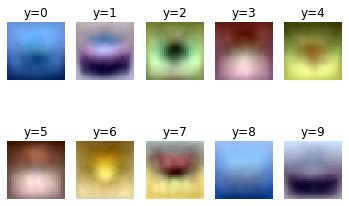

Accuracy on training data: 0.2929795918367347
Accuracy on validation data: 0.304
Accuracy on test data: 0.2999


In [56]:
#Bonus - Train on all data
X_train1, Y_train1, y_train_oh_1 = LoadBatch('data_batch_1')
X_train2, Y_train2, y_train_oh_2 = LoadBatch('data_batch_2')
X_train3, Y_train3, y_train_oh_3 = LoadBatch('data_batch_3')
X_train4, Y_train4, y_train_oh_4 = LoadBatch('data_batch_4')
X_train5, Y_train5, y_train_oh_5 = LoadBatch('data_batch_5')



X_train = np.vstack((X_train1, X_train2, X_train3, X_train4, X_train5))
Y_train = np.hstack((Y_train1, Y_train2, Y_train3, Y_train4, Y_train5))
y_train_oh = np.vstack((y_train_oh_1, y_train_oh_2, y_train_oh_3, y_train_oh_4, y_train_oh_5))

X_test, Y_test, y_test_oh = LoadBatch('test_batch')

X_val = X_train[-1000:, :]
Y_val = Y_train[-1000:]
y_val_oh = y_train_oh[-1000:, :]

X_train = X_train[:-1000, :]
Y_train = Y_train[:-1000]
y_train_oh = y_train_oh[:-1000, :]

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

#Normalized data
img_trn_nrm = normalize(X_train, mean, std)
img_val_nrm = normalize(X_val, mean, std)
img_test_nrm = normalize(X_test, mean, std)


W = np.random.normal(0, 0.01, (10, img_trn_nrm.shape[1]))
b = np.random.normal(0, 0.01, (10, 1))

n_batch = 100
eta = 0.001
n_epochs = 40
lamda = 1
total_samples = img_trn_nrm.shape[0]
#Training and Validation
w_star, b_star = mini_batch_gd(total_samples, n_batch, img_trn_nrm, y_train_oh, img_val_nrm, y_val_oh,
                                          Y_train, Y_val, eta, n_epochs, W, b, lamda)
#show image
montage(w_star)

#Accuracy
train_acc = ComputeAccuracy(img_trn_nrm, Y_train, w_star, b_star)
print('Accuracy on training data: ' + str(train_acc))
val_acc = ComputeAccuracy(img_val_nrm, Y_val, w_star, b_star)
print('Accuracy on validation data: ' + str(val_acc))
test_acc = ComputeAccuracy(img_test_nrm, Y_test, w_star, b_star)
print('Accuracy on test data: ' + str(test_acc))



In [114]:
a = np.array([[1,2,3,4,5,6,7], [8,9,10,11,12,13,14], [18,19,110,111,112,113,114]])
b = np.array([1,2,3,4,5,6,7])

print(a[:, 0:5])

# a_row = a[-2:, :]
# a_col = a[:, -2:]
# a_col_del = a[:, :-2]
# a_row_del = a[:-2, :]
# print(a_col)
# print(a_col_del)

# for i in range(len(a)):
#     a_shu, b_shu = shuffle(a, b)
#     print(a_shu)
#     print(b_shu)

[[  1   2   3   4   5]
 [  8   9  10  11  12]
 [ 18  19 110 111 112]]
